# DASC 512 - 17 - Confidence Intervals

***


In [47]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.graphics.api as smg

sns.set_style('whitegrid')

## What does a confidence interval mean?
If you'd like, you can copy the below code. It runs a simulation of creating many confidence intervals from samples of a distribution and shows how many of them include the actual parameter.

In [122]:
def ci_experiment(pop_dist=None, confidence=0.9, n=50, bigN=100, figsize=(4,6)):
    '''
    This function simulates bigN samples of size n from the pop_dist distribution
    and shows the confidence intervals calculated from each sample.
    This illustrates what is meant by a confidence interval.
    
    Inputs:
    pop_dist   : A parameterized distribution from scipy.stats. If omitted, will use standard normal
                 This is the distribution of the population, not the sampling distribution
    confidence : The confidence used for the intervals
    n          : The sample size of each simulated sample
    bigN       : The number of simulations to run
    figsize    : Sets the figure size. Defaults to 4x6. This should be a two element numerical tuple
    
    Returns:
    fig        : A figure object containing the plot
    hits       : The number of intervals that included the mean
    '''
    import scipy.stats as stats
    import numpy as np
    if pop_dist == None:
        pop_dist = stats.norm()
    mu = pop_dist.expect()
    fig, ax = plt.subplots(figsize=figsize)
    misses = 0
    for i in range(bigN):
        data = pop_dist.rvs(size=n)
        ci = stats.t(df=n-1, loc=data.mean(), scale=data.std(ddof=1)/np.sqrt(n)).interval(confidence)
        color = 'C0'
        if (mu < ci[0]) or (mu > ci[1]):
            color = 'red'
            misses += 1
        ax.broken_barh([(ci[0], ci[1]-ci[0])], (i-0.4, 0.8), facecolor=color, edgecolor='black')
    ax.axvline(x=mu)
    fig.tight_layout()
    return fig, (bigN - misses)

90 intervals included the actual mean.


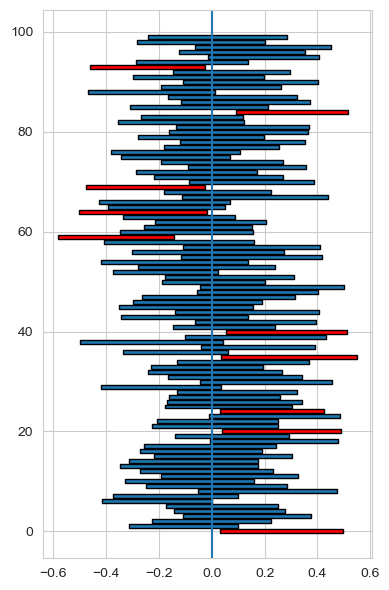

In [140]:
fig, hits = ci_experiment(confidence=0.9)
print(f'{hits} intervals included the actual mean.')
plt.show()

## Normal Confidence Intervals
These confidence intervals are most commonly used for large sample sizes when we can reasonably assume the sampling distribution is normal.

If it helps to visualize an interval, feel free to use this code.

In [39]:
def plot_ci(interval, dist=None, xlim=[-4,4], figsize=(4,2)):
    '''
    This function plots a distribution and fills the area covered by the confidence given.
    The pdf is filled between the limits of the interval.
    
    Inputs:
    interval : A two-element numerical tuple containing the left and right bounds of the interval
               For one-sided intervals, include math.inf or -math.inf as appropriate
    dist     : A parameterized distribution from scipy.stats. If omitted, will use standard normal
    xlim     : The range of x values you want to plot. If omitted, defaults to [-4,4]
    figsize  : Sets the figure size. Defaults to 4x2. This should be a two element numerical tuple
    
    Returns:
    fig      : A figure object containing the plot
    '''
    import scipy.stats as stats
    import numpy as np
    if dist == None:
        dist = stats.norm()
    pdfx = np.linspace(xlim[0],xlim[1],1000)
    pdf = [dist.pdf(xx) for xx in pdfx]
    ci = (max(xlim[0], interval[0]),min(xlim[1], interval[1]))
    fillx = np.linspace(ci[0], ci[1], 1000)
    filly = [dist.pdf(xx) for xx in fillx]
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(pdfx, pdf)
    ax.fill_between(x=fillx, y1=0, y2=filly, color='C0', alpha=0.5, 
                    label=f'Confidence: {dist.cdf(interval[1])-dist.cdf(interval[0]):.3f}'
                   )
    ax.legend()
    ax.set_xlim(xlim)
    ax.set_ylabel('pdf')
    fig.tight_layout()
    return fig

In [2]:
mu = 5
sigma = 2
dist = stats.norm(loc=mu, scale=sigma)

To build a confidence intervals, find points in the distribution that covers a given percentage of the area.

So, for a symmetric 95% confidence interval, we want 2.5% of outcomes to the left of the left bound and 2.5% of outcomes to the right of the right bound.

In [42]:
lower = dist.ppf(.025)
lower

1.080072030919891

In [43]:
upper = dist.isf(.025)
upper

8.91992796908011

In [44]:
# Or you can stick with the ppf
upper = dist.ppf(.975)
upper

8.919927969080108

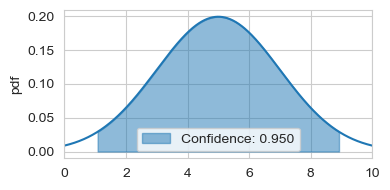

In [45]:
plot_ci(interval=(lower, upper), dist=dist, xlim=[0,10])
plt.show()

We can also just use the scipy.stats .interval function. Note that confusingly, the parameter for this function is called alpha but is actually confidence. As of SciPy version 1.9.0, the parameter is renamed confidence. Anaconda 2022.05 still uses SciPy version 1.7.3, so we'll use alpha here.

In [14]:
dist.interval(alpha=0.95)

(1.080072030919892, 8.919927969080108)

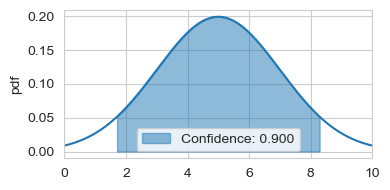

In [48]:
plot_ci(interval=dist.interval(0.9), dist=dist, xlim=[0,10])
plt.show()

Note that an interval does not have to be symmetric! All of the below are valid 95% Confidence Intervals. However, unless specified otherwise, assume a symmetric interval, because that's usually what people expect.

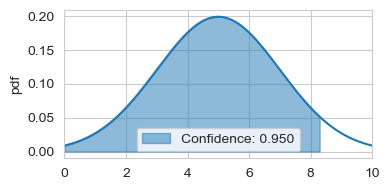

In [50]:
# A 95% confidence one-sided interval, if you care most about a lower or upper bound
interval = (-math.inf, dist.isf(.05))
plot_ci(interval=interval, dist=dist, xlim=[0,10])
plt.show()

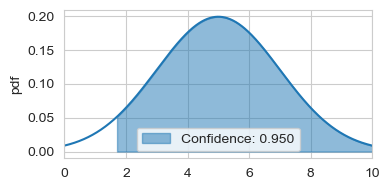

In [51]:
interval = (dist.ppf(.05), math.inf)
plot_ci(interval=interval, dist=dist, xlim=[0,10])
plt.show()

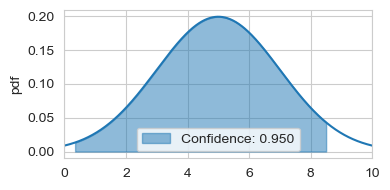

In [52]:
# These are also perfectly valid, although I can't think of a legitimate usage.
interval = (dist.ppf(.01), dist.isf(.04))
plot_ci(interval=interval, dist=dist, xlim=[0,10])
plt.show()

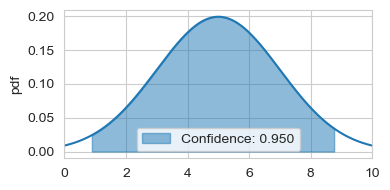

In [54]:
interval = (dist.ppf(.02), dist.isf(.03))
plot_ci(interval=interval, dist=dist, xlim=[0,10])
plt.show()

## Student *t* Confidence Intervals
These confidence intervals are used for smaller sample sizes when we can reasonably assume the population distribution is approximately normal. 

There's no reason to use the normal confidence intervals even at large sample sizes anymore.

In [141]:
dist = stats.t(df=5, loc=5, scale=2)
dist.interval(0.95)

(-0.14116367322947898, 10.141163673229478)

In [142]:
# For comparison, if we used the normal distribution
stats.norm(loc=5, scale=2).interval(0.95)

(1.080072030919892, 8.919927969080108)

The difference between the distributions decreases as sample size increases, but there is no magic number when they are equivalent. Not even 30.

In [145]:
print(stats.t(df=30, loc=5, scale=2).interval(0.95))
print(stats.norm(loc=5, scale=2).interval(0.95))

(0.9154550873975253, 9.084544912602475)
(1.080072030919892, 8.919927969080108)


## Binomial Confidence Intervals
The same functions work for binomial distributions as well.

Isn't it so much easier to think of CIs probabilistically instead of using cookbook formulas?

In [146]:
dist = stats.binom(p=0.9, n=100)
dist.interval(0.95)

(84.0, 95.0)

Note that this is the confidence interval for the number of intervals in our experiment at the beginning of the lesson that will cover the actual parameter value!

## Prediction Intervals
Prediction intervals are similar to confidence intervals, but applied to prediction of new data rather than the actual parameter. You must scale the t distribution's 

"Within what range are you 90% confident that the actual mean lies?" --- Confidence Interval

"Within what range are you 90% confident that the next observation will lie?" --- Prediction Interval

In [154]:
pop_dist = stats.norm(loc=5, scale=2)
n = 50
data = pop_dist.rvs(size=n)
ci = stats.t(df=n-1, loc=data.mean(), scale=data.std(ddof=1)*np.sqrt(1/n)).interval(0.9)
pi = stats.t(df=n-1, loc=data.mean(), scale=data.std(ddof=1)*np.sqrt(1+1/n)).interval(0.9)
print(f'I am 90% confident that the mean is in the range ({ci[0]:.2f}, {ci[1]:.2f}). It is actually 5.')
print(f'I am 90% confident that the next observation will be in the range ({pi[0]:.2f}, {pi[1]:.2f}).'
      f' The next observation is actually {pop_dist.rvs():.2f}.')

I am 90% confident that the mean is in the range (4.64, 5.51). It is actually 5.
I am 90% confident that the next observation will be in the range (1.95, 8.21). The next observation is actually 2.43.


In [185]:
def pi_experiment(pop_dist=None, confidence=0.9, n=50, figsize=(3,1)):
    '''
    This function simulates 100 new data points after creating a prediction interval.
    This illustrates what is meant by a prediction interval.
    
    Inputs:
    pop_dist   : A parameterized distribution from scipy.stats. If omitted, will use standard normal
                 This is the distribution of the population, not the sampling distribution
    confidence : The confidence used for the intervals
    n          : The sample size of each simulated sample
    figsize    : Sets the figure size. This should be a two element numerical tuple
    
    Returns:
    fig        : A figure object containing the plot
    hits       : The number of data points captured by the interval
    '''
    import scipy.stats as stats
    import numpy as np
    if pop_dist == None:
        pop_dist = stats.norm()
    data = pop_dist.rvs(size=n)
    pi = stats.t(df=n-1, loc=data.mean(), scale=data.std(ddof=1)*np.sqrt(1+1/n)).interval(confidence)
    fig, ax = plt.subplots(figsize=figsize)
    ax.broken_barh([(pi[0], pi[1]-pi[0])], (0.6,0.8), alpha=0.7)
    new_data = pop_dist.rvs(size=1000)
    ax.scatter(x=new_data, y=np.ones(1000), marker='.')
    misses = sum(new_data < pi[0]) + sum(new_data > pi[1])
    mu = pop_dist.expect()
    ax.set_yticks([])
    fig.tight_layout()
    return fig, (1000 - misses)

The interval included 929/1000 new points.


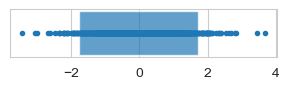

In [198]:
fig, hits = pi_experiment(confidence=0.9)
print(f'The interval included {hits}/1000 new points.')
plt.show()